In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import datatransformation as data

In [75]:
events = data.GetStatsbombData().get_event_files('Champions League')

In [102]:

class ShotDistance:
    def create_gk_shot_dataframe(df):
        gk_df = df[df['event_name'] == 'Goal Keeper']
        shot_df = df[df['event_name'] == 'Shot']
        shot_id = shot_df[['id', 'related_events']].explode('related_events').dropna(subset=['related_events'])

        merge_gk = shot_id.merge(gk_df[['id', 'event_name', 'goalkeeper', 'location']], how='left', left_on='related_events', right_on='id') \
                    .dropna() \
                        .drop(columns=['id_y']) \
                            .merge(shot_df[['id', 'minute', 'second', 'event_name', 'shot', 'location']], how='left', left_on='id_x', right_on='id')

        gk_exp = merge_gk['goalkeeper'].apply(pd.Series)[['outcome', 'type', 'position', 'technique', 'body_part']]
        shot_exp = merge_gk['shot'].apply(pd.Series)[['outcome', 'type', 'technique', 'body_part']]

        merge_df = pd.DataFrame()
        for column in gk_exp:
            exp_col = pd.concat([gk_exp.drop([column], axis=1), gk_exp[column].apply(pd.Series)], axis=1).rename(columns={'name': 'gk_' + column}).drop(['id'], axis=1)
            merge_df = pd.concat([merge_df, exp_col['gk_' + column]], axis=1)


        for column in shot_exp:
            exp_col = pd.concat([shot_exp.drop([column], axis=1), shot_exp[column].apply(pd.Series)], axis=1).rename(columns={'name': 'shot_' + column}).drop(['id'], axis=1)
            merge_df = pd.concat([merge_df, exp_col['shot_' + column]], axis=1)

        gk_shots = pd.concat([merge_gk.drop(['goalkeeper', 'shot'], axis=1), merge_df, merge_gk['shot'].apply(pd.Series)[['statsbomb_xg', 'one_on_one']]], axis=1)

        return gk_shots

    def create_shot_model(df):
        shot_model = df.loc[(df['gk_type'].isin(['Goal Conceded', 'Shot Saved'])) \
                & (df['shot_type'] == 'Open Play') \
                    & (df['gk_position'] != 'Prone')] \
                        [['id', 'location_x', 'location_y', 'gk_type', 'gk_technique', 'shot_outcome', 'shot_technique', 'shot_body_part', 'statsbomb_xg']]\
                            .reset_index()
        shot_model['gk_pos_x'] = [i[1] for i in shot_model['location_x']]
        shot_model['gk_pos_x'] = 80 - shot_model['gk_pos_x']
        shot_model['gk_pos_y'] = [i[0] for i in shot_model['location_x']]
        shot_model['gk_pos_y'] = 120 - shot_model['gk_pos_y']
        shot_model['shot_pos_x'] = [i[1] for i in shot_model['location_y']] # Pitch Rotation transforms y to x value
        shot_model['shot_pos_y'] = [i[0] for i in shot_model['location_y']] # Pitch Rotation transforms x to y value

        temp_df = pd.DataFrame()
        for i in range(len(shot_model)):
            # GK Distance to Shot
            gk_dis = pd.Series(np.hypot([int(shot_model['gk_pos_x'][i]) - int(shot_model['shot_pos_x'][i])], \
                                        [int(shot_model['gk_pos_y'][i]) - int(shot_model['shot_pos_y'][i])])[0], name='gk_dis').astype(int)
            # # Shot Distance to Goal Line
            shot_dis_gl = pd.Series(np.hypot([40 - int(shot_model['shot_pos_x'][i])], \
                                            [120 - int(shot_model['shot_pos_y'][i])])[0], name='shot_dis_gl').astype(int)
            # # Angle of the Shot from the Goal Line
            shot_angle = np.rad2deg(np.arccos([40 - int(shot_model['shot_pos_x'][i])] / shot_dis_gl)).astype(int)
            shot_angle = [x - 90 if x > 90 else x for x in shot_angle][0]
            shot_angle = pd.Series(shot_angle, name='shot_angle')

            temp_df = pd.concat([temp_df, pd.concat([gk_dis*0.9, shot_dis_gl*0.9, shot_angle], axis=1)])


        shot_model = pd.concat([shot_model, temp_df.reset_index()], axis=1)                        
        
        return shot_model[['gk_type', 'gk_technique', 'shot_body_part', 'statsbomb_xg', 'gk_dis', 'shot_dis_gl', 'shot_angle']]

In [103]:
gk_shots = ShotDistance.create_gk_shot_dataframe(events)
shot_model = ShotDistance.create_shot_model(gk_shots)

In [80]:
shot_model.describe()

,statsbomb_xg,gk_dis,shot_dis_gl,shot_angle
count,130.000000,130.000000,130.000000,130.000000
mean,0.135259,12.939231,16.123846,48.123077
std,0.153001,8.585281,8.162960,26.099397
min,0.008989,0.900000,2.700000,2.000000
25%,0.029622,6.300000,10.800000,25.000000
50%,0.063548,11.700000,14.400000,52.000000
75%,0.202387,19.575000,21.600000,68.000000
max,0.768034,55.800000,57.600000,90.000000


In [86]:
shot_model.sort_values('shot_dis_gl', ascending=False).head()

,gk_type,gk_technique,shot_body_part,statsbomb_xg,gk_dis,shot_dis_gl,shot_angle
90,Shot Saved,Standing,Right Foot,0.019080,55.8,57.6,90
17,Shot Saved,Standing,Right Foot,0.009500,33.3,34.2,21
104,Shot Saved,Standing,Right Foot,0.027525,27.0,33.3,25
47,Shot Saved,Standing,Right Foot,0.008989,27.9,30.6,88
57,Goal Conceded,Standing,Left Foot,0.013965,28.8,30.6,31


<AxesSubplot:xlabel='gk_dis', ylabel='Count'>

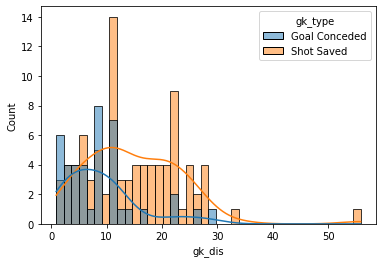

In [84]:
goal = shot_model[shot_model['gk_type'] == 'Goal Conceded']
saves = shot_model[shot_model['gk_type'] == 'Shot Saved']
# sns.histplot(data=shot_model, x='gk_dis', stat='count')
sns.histplot(data=shot_model, x='gk_dis', stat='count', kde=True, hue='gk_type', bins=40)

<AxesSubplot:xlabel='gk_dis', ylabel='Probability'>

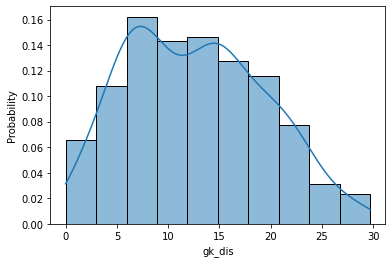

In [71]:
sns.histplot(data=saves, x='gk_dis', stat='probability', kde=True)